In [12]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from datetime import datetime 
import calendar
import math
# Importing the most popular regression libraries.
from sklearn.linear_model import LinearRegression 
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from xgboost import XGBRegressor
from pandas.util._decorators import Appender
#from pmdarima.arima import auto_arima
from statsmodels.tsa.arima_model import ARIMA

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [13]:
#Loading the data from csv files.
train=pd.read_csv('train.csv')
features=pd.read_csv('features.csv')
stores = pd.read_csv('stores.csv')

In [14]:
data = train.merge(features, on=['Store', 'Date'], how='inner').merge(stores, on=['Store'], how='inner')
print(data.shape)

(421570, 17)


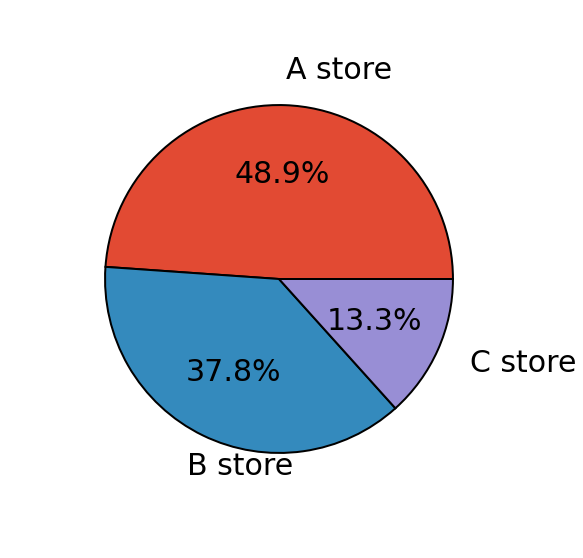

In [15]:
#We came to know that Type A stores have their medians higher than any other medians in other store types,
#so the weekly sales for store type A is more than other store types.
sorted_type = stores.groupby('Type')
plt.style.use('ggplot')
labels=['A store','B store','C store']
sizes=sorted_type.describe()['Size'].round(1)
sizes=[(22/(17+6+22))*100,(17/(17+6+22))*100,(6/(17+6+22))*100] # convert to the proportion
fig, axes = plt.subplots(1,1, figsize=(10,10))
wprops={'edgecolor':'black',
      'linewidth':2}
tprops = {'fontsize':30}
axes.pie(sizes,
        labels=labels,
        explode=(0.0,0,0),
        autopct='%1.1f%%',
        pctdistance=0.6,
        labeldistance=1.2,
        wedgeprops=wprops,
        textprops=tprops,
        radius=0.8,
        center=(0.5,0.5))
plt.show()

In [16]:
print(data)

        Store  Dept        Date  ...  IsHoliday_y  Type    Size
0           1     1  2010-02-05  ...        False     A  151315
1           1     2  2010-02-05  ...        False     A  151315
2           1     3  2010-02-05  ...        False     A  151315
3           1     4  2010-02-05  ...        False     A  151315
4           1     5  2010-02-05  ...        False     A  151315
...       ...   ...         ...  ...          ...   ...     ...
421565     45    93  2012-10-26  ...        False     B  118221
421566     45    94  2012-10-26  ...        False     B  118221
421567     45    95  2012-10-26  ...        False     B  118221
421568     45    97  2012-10-26  ...        False     B  118221
421569     45    98  2012-10-26  ...        False     B  118221

[421570 rows x 17 columns]


In [17]:
data.shape

(421570, 17)

In [18]:
data.describe

<bound method NDFrame.describe of         Store  Dept        Date  ...  IsHoliday_y  Type    Size
0           1     1  2010-02-05  ...        False     A  151315
1           1     2  2010-02-05  ...        False     A  151315
2           1     3  2010-02-05  ...        False     A  151315
3           1     4  2010-02-05  ...        False     A  151315
4           1     5  2010-02-05  ...        False     A  151315
...       ...   ...         ...  ...          ...   ...     ...
421565     45    93  2012-10-26  ...        False     B  118221
421566     45    94  2012-10-26  ...        False     B  118221
421567     45    95  2012-10-26  ...        False     B  118221
421568     45    97  2012-10-26  ...        False     B  118221
421569     45    98  2012-10-26  ...        False     B  118221

[421570 rows x 17 columns]>

In [19]:
data.dtypes

Store             int64
Dept              int64
Date             object
Weekly_Sales    float64
IsHoliday_x        bool
Temperature     float64
Fuel_Price      float64
MarkDown1       float64
MarkDown2       float64
MarkDown3       float64
MarkDown4       float64
MarkDown5       float64
CPI             float64
Unemployment    float64
IsHoliday_y        bool
Type             object
Size              int64
dtype: object

In [20]:
master_df=data

In [21]:
master_df=master_df.fillna(0)
master_df.isna().sum()
master_df = master_df[master_df['Weekly_Sales'] >= 0]
# Cleaning holiday columns
master_df['IsHoliday'] = master_df['IsHoliday_x']
master_df = master_df.drop(columns=['IsHoliday_x', 'IsHoliday_y'])

In [22]:
master_df['Date'] = pd.to_datetime(master_df['Date'], format='%Y-%m-%d')
master_df['Week_Number'] = master_df['Date'].dt.week
master_df['Quarter'] = master_df['Date'].dt.quarter
master_df['Month'] = master_df['Date'].dt.month.apply(lambda x: calendar.month_abbr[x])
master_df["Year"] = master_df["Date"].dt.year

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  


In [23]:
master_df.dtypes

Store                    int64
Dept                     int64
Date            datetime64[ns]
Weekly_Sales           float64
Temperature            float64
Fuel_Price             float64
MarkDown1              float64
MarkDown2              float64
MarkDown3              float64
MarkDown4              float64
MarkDown5              float64
CPI                    float64
Unemployment           float64
Type                    object
Size                     int64
IsHoliday                 bool
Week_Number              int64
Quarter                  int64
Month                   object
Year                     int64
dtype: object

In [24]:
master_df.isna().sum()

Store           0
Dept            0
Date            0
Weekly_Sales    0
Temperature     0
Fuel_Price      0
MarkDown1       0
MarkDown2       0
MarkDown3       0
MarkDown4       0
MarkDown5       0
CPI             0
Unemployment    0
Type            0
Size            0
IsHoliday       0
Week_Number     0
Quarter         0
Month           0
Year            0
dtype: int64

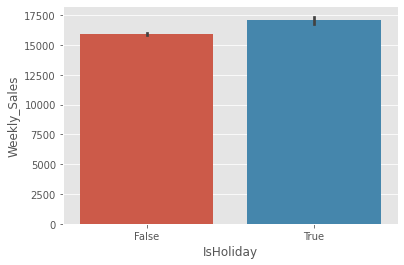

In [25]:
holiday = master_df['Weekly_Sales'].loc[master_df['IsHoliday']== True] # Weekly Sales in Holidays
non_holiday = master_df['Weekly_Sales'].loc[master_df['IsHoliday']== False] #Weekly Sales in Non-holidays.
sns.barplot(x='IsHoliday', y='Weekly_Sales', data=master_df)

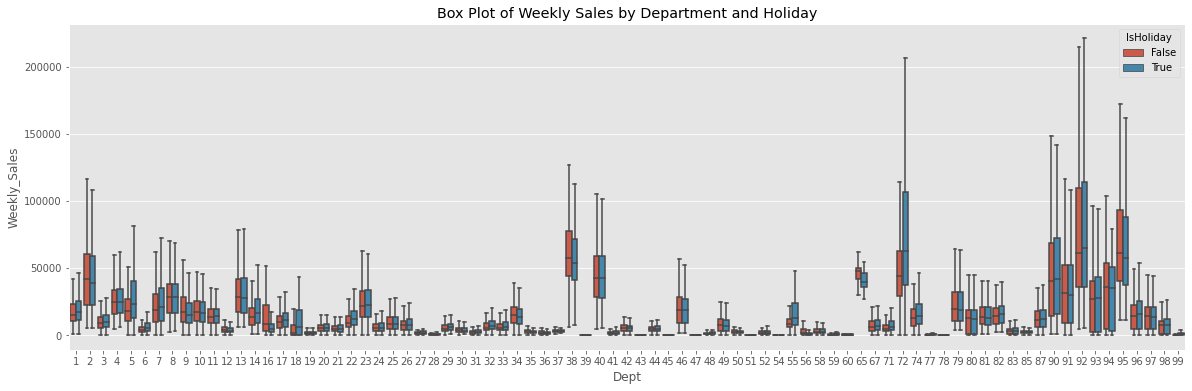

In [26]:
data_11= pd.concat([master_df['Dept'], master_df['Weekly_Sales'], master_df['IsHoliday']], axis=1)
plt.figure(figsize=(20,6))
plt.title('Box Plot of Weekly Sales by Department and Holiday')
fig = sns.boxplot(x='Dept', y='Weekly_Sales', data=data_11, showfliers=False, hue="IsHoliday")

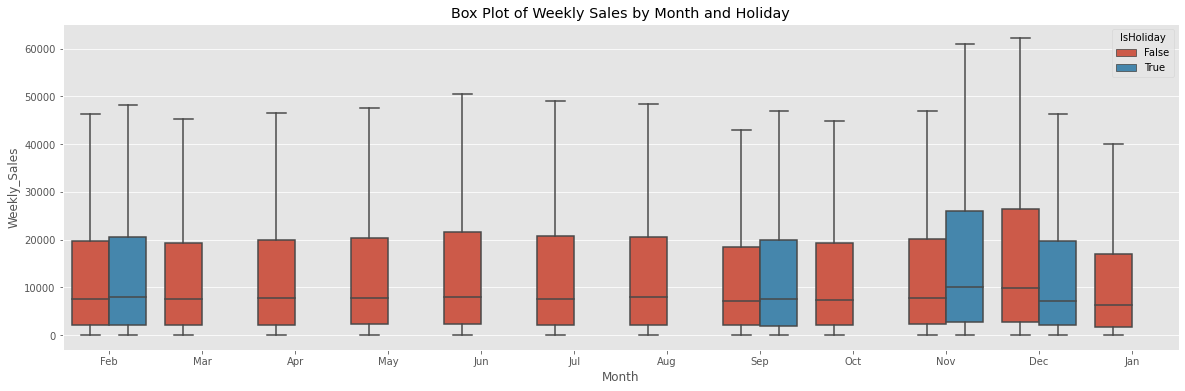

In [27]:
data_14 = pd.concat([master_df['Month'], master_df['Weekly_Sales'], master_df['IsHoliday']], axis=1)
plt.figure(figsize=(20,6))
plt.title('Box Plot of Weekly Sales by Month and Holiday')
fig = sns.boxplot(x='Month', y='Weekly_Sales', data=data_14, showfliers=False, hue='IsHoliday')

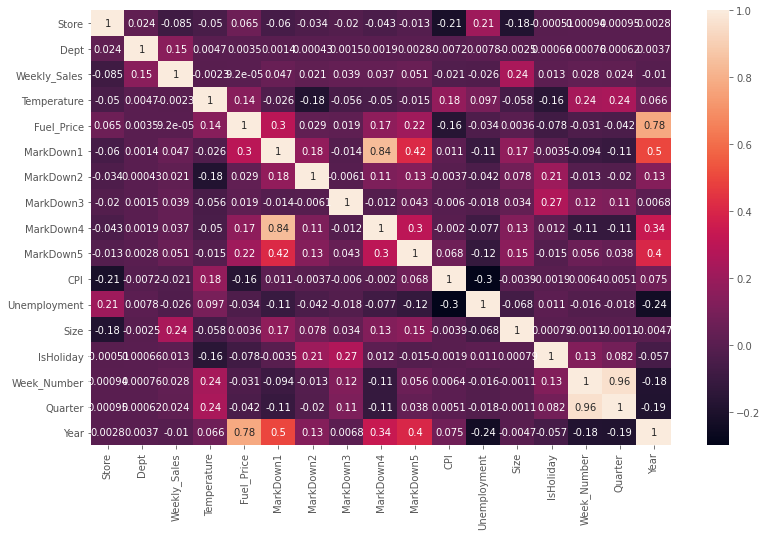

In [28]:
plt.figure(figsize=(13,8))
sns.heatmap(master_df.corr('pearson'), annot = True)

In [29]:
master_df2=master_df.copy()

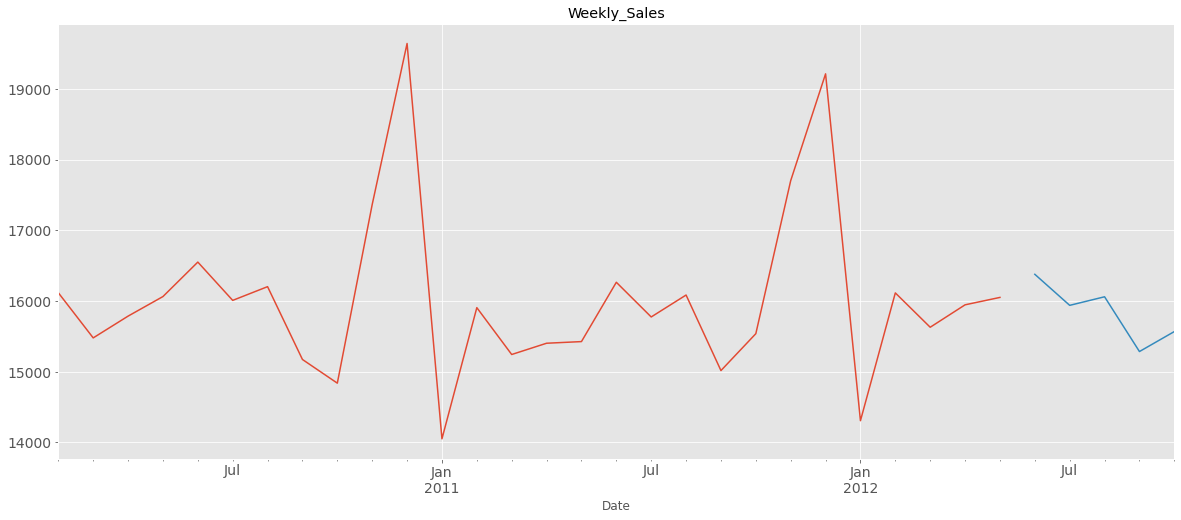

In [30]:
master_df.Date = pd.to_datetime(master_df.Date,format='%Y-%m-%d')
master_df.index = master_df.Date
master_df = master_df.drop('Date', axis=1)
master_df = master_df.resample('MS').mean() # Resmapling the time series data with month starting first.
# -Test splitting of time series data
_data = master_df[:int(0.85*(len(master_df)))]
test_data = master_df[int(0.85*(len(master_df))):]
# ARIMA takes univariate data.
_data = _data['Weekly_Sales']
test_data = test_data['Weekly_Sales']
# Plot of Weekly_Sales with respect to years in  and test.
_data.plot(figsize=(20,8), title= 'Weekly_Sales', fontsize=14)
test_data.plot(figsize=(20,8), title= 'Weekly_Sales', fontsize=14)
plt.show()

In [31]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(master_df['Weekly_Sales'])
print('ADF Statistic: {}'.format(result[0]))
print('p-value: {}'.format(result[1]))
print('Critical Values:')
for key, value in result[4].items():
    print('\t{}: {}'.format(key, value))

ADF Statistic: -4.173916935101529
p-value: 0.0007291844915316654
Critical Values:
	1%: -3.769732625845229
	5%: -3.005425537190083
	10%: -2.6425009917355373


<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:           Weekly_Sales   No. Observations:                   33
Model:                     ARMA(2, 1)   Log Likelihood                -273.765
Method:                       css-mle   S.D. of innovations            926.244
Date:                Sun, 27 Jun 2021   AIC                            557.531
Time:                        12:30:48   BIC                            565.013
Sample:                    02-01-2010   HQIC                           560.048
                         - 10-01-2012                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               1.603e+04     25.263    634.625      0.000     1.6e+04    1.61e+04
ar.L1.Weekly_Sales     0.6123      0.168      3.653      0.001       0.284       0.941
ar.L2.Weekly_Sales    -0.2458      0.165     -1.488      0.148      -0.570       0.078
ma.L1.Weekly_Sales    -1.0000      0.087    -11.477      0.000      -1.171      -0.829
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.2453           -1.5865j            2.0169           -0.1441
AR.2            1.2453           +1.5865j            2.0169            0.1441
MA.1            1.0000           +0.0000j            1.0000            0.0000
-----------------------------------------------------------------------------
"""

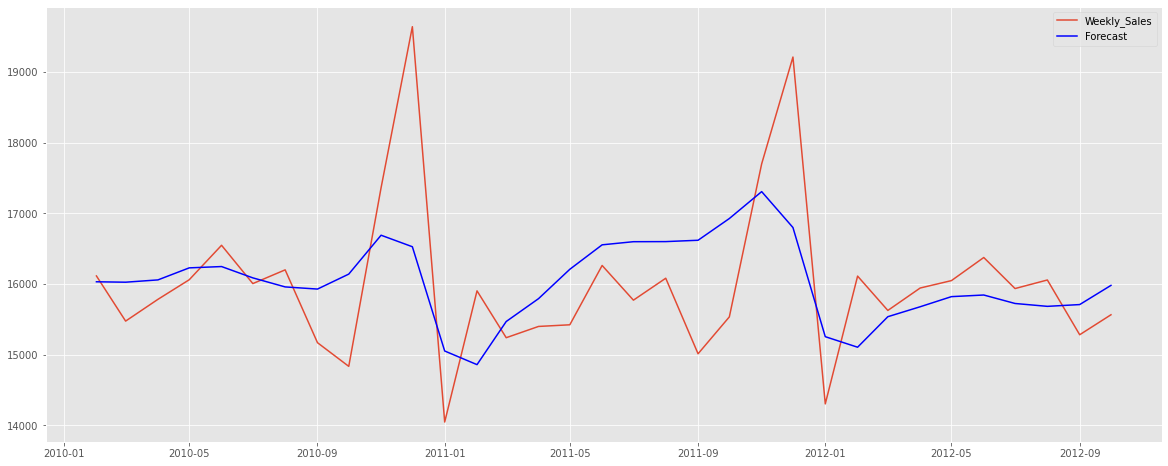

In [54]:
#https://stackoverflow.com/questions/24316935/python-statsmodel-arima-start-stationarity
fig = plt.figure(figsize=(20,8))
model = ARIMA(master_df['Weekly_Sales'], order=(2,0,1)) 
ax = plt.gca()
results = model.fit() 
plt.plot(master_df['Weekly_Sales'])
plt.plot(results.fittedvalues, color='blue')
ax.legend(['Weekly_Sales', 'Forecast'])

results.summary()

In [33]:
master_df.index

DatetimeIndex(['2010-02-01', '2010-03-01', '2010-04-01', '2010-05-01',
               '2010-06-01', '2010-07-01', '2010-08-01', '2010-09-01',
               '2010-10-01', '2010-11-01', '2010-12-01', '2011-01-01',
               '2011-02-01', '2011-03-01', '2011-04-01', '2011-05-01',
               '2011-06-01', '2011-07-01', '2011-08-01', '2011-09-01',
               '2011-10-01', '2011-11-01', '2011-12-01', '2012-01-01',
               '2012-02-01', '2012-03-01', '2012-04-01', '2012-05-01',
               '2012-06-01', '2012-07-01', '2012-08-01', '2012-09-01',
               '2012-10-01'],
              dtype='datetime64[ns]', name='Date', freq='MS')

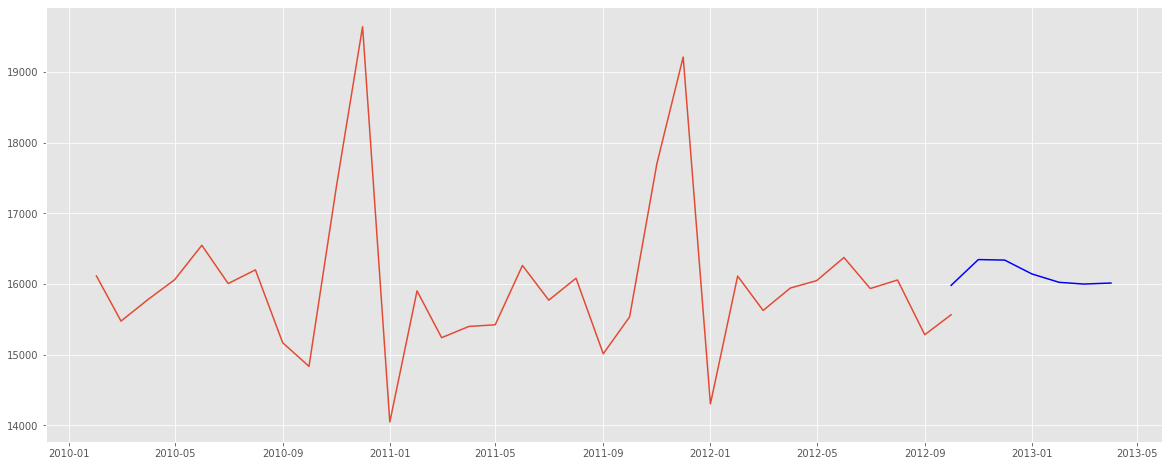

In [34]:

fig = plt.figure(figsize=(20,8))
#num_points = len(clear_data['car.count'])
x = results.predict(start=("2012-10-01"), end=("2013-04-01"), dynamic=False)

plt.plot(master_df["Weekly_Sales"])
plt.plot(x, color='b')

In [35]:
# # Applying auto_arima model on  data.
# model_auto_arima = auto_arima(_data, trace=True, error_action='ignore', suppress_warnings=True)
# model_auto_arima = auto_arima(_data, trace=True,start_p=0, start_q=0, start_P=0, start_Q=0, max_p=10, max_q=10, max_P=10, max_Q=10, seasonal=True,stepwise=False, suppress_warnings=True, D=1, max_D=10,error_action='ignore',approximation = False)
# model_auto_arima.fit(_data)

In [36]:
# # Predicting the test values using predict function.
# forecast = model_auto_arima.predict(n_periods=len(test_data))
# forecast = pd.DataFrame(forecast,index = test_data.index,columns=['Prediction'])
# plt.figure(figsize=(20,6))
# plt.title('Prediction of Weekly Sales using Auto ARIMA model', fontsize=20)
# plt.plot(_data, label='')
# plt.plot(test_data, label='Test')
# plt.plot(forecast, label='Prediction using ARIMA Model')
# plt.legend(loc='best')
# plt.xlabel('Date', fontsize=14)
# plt.ylabel('Weekly Sales', fontsize=14)
# plt.show()

In [37]:
# # Performance metric for ARIMA model -MSE/RMSE
# print('Mean Squared Error (MSE) of ARIMA: ', mean_squared_error(test_data, forecast))
# print('Root Mean Squared Error (RMSE) of ARIMA: ', math.sqrt(mean_squared_error(test_data, forecast)))
# print('Mean Absolute Deviation (MAD) of ARIMA: ', mean_absolute_error(test_data, forecast))

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


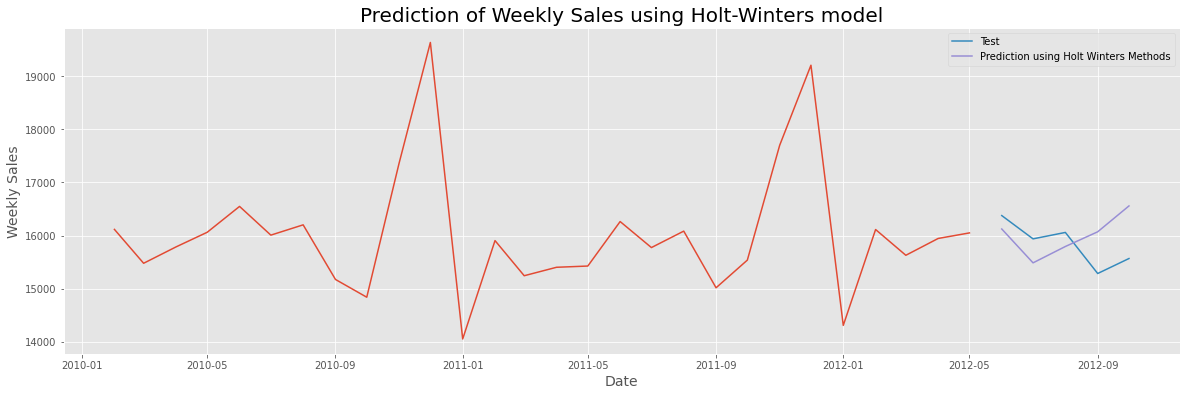

In [38]:
# Fitting the Holt-Winters method for Weekly Sales.
from statsmodels.tsa.api import ExponentialSmoothing
model_holt_winters = ExponentialSmoothing(_data, seasonal_periods=7, trend='additive', seasonal='additive').fit() 
pred = model_holt_winters.forecast(len(test_data))# Predict the test data
#Visualize , test and predicted data.
plt.figure(figsize=(20,6))
plt.title('Prediction of Weekly Sales using Holt-Winters model', fontsize=20)
plt.plot(_data, label='')
plt.plot(test_data, label='Test')
plt.plot(pred, label='Prediction using Holt Winters Methods')
plt.legend(loc='best')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Weekly Sales', fontsize=14)
plt.show()

In [39]:
print('Mean Squared Error (MSE) of Holt-Winters: ', mean_squared_error(test_data, pred))
print('Root Mean Squared Error (RMSE) of Holt-Winters: ', math.sqrt(mean_squared_error(test_data, pred)))
print('Mean Absolute Deviation (MAD) of Holt-Winters: ', mean_absolute_error(test_data, pred))

Mean Squared Error (MSE) of Holt-Winters:  388409.6112769923
Root Mean Squared Error (RMSE) of Holt-Winters:  623.2251690015354
Mean Absolute Deviation (MAD) of Holt-Winters:  549.8500311065163


In [40]:

# df=master_df2[['Store','Dept','Date','Weekly_Sales','Size','IsHoliday']]
# df

In [41]:

# # Converting Categorical Variable 'IsHoliday' into Numerical Variables.
# type_mapping = {False: 0, True: 1}
# df['IsHoliday'] = df['IsHoliday'].map(type_mapping)
# df

In [42]:
# df['Super_Bowl'] = np.where(
# (df['Date']==datetime(2010,2,10))|
# (df['Date'] == datetime(2011,2,11))| 
# (df['Date'] == datetime(2012,2,10))|
# (df['Date'] == datetime(2013,2,8)), 1, 0)
# df['Labor_day'] = np.where(
# (df['Date'] == datetime(2010,9,10))|
# (df['Date'] == datetime(2011,9,9))| 
# (df['Date'] == datetime(2012,9,7))|
# (df['Date'] == datetime(2013,9,6)), 1, 0)
# df['Thanksgiving'] = np.where(
# (df['Date']==datetime(2010, 11, 26)) | (df['Date']==datetime(2011, 11, 25)) | 
# (df['Date']==datetime(2012, 11, 23)) | (df['Date']==datetime(2013, 11, 29)),1,0)
# df['Christmas'] = np.where(
# (df['Date']==datetime(2010, 12, 31))| (df['Date']==datetime(2011, 12, 30))| 
# (df['Date']==datetime(2012, 12, 28))| (df['Date']==datetime(2013, 12, 27)),1,0)

# df

In [43]:
# df = df.sort_values(by='Date', ascending=True) # Sorting the data in increasing order of Date and then splitting.
# y = df['Weekly_Sales']
# X = df.drop(['Weekly_Sales'], axis=1)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3) # Train:Test = 70:30 splitting.
# X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.3) #Train:CV = 70:30 splitting.

In [44]:
# def wmae_train(test, pred): 
#   weights = X_train['IsHoliday'].apply(lambda is_holiday:5 if   is_holiday else 1)
#   error = np.sum(weights * np.abs(test - pred), axis=0) / np.sum(weights)
#   return error
# def wmae_cv(test, pred): # WMAE for CV
#   weights = X_cv['IsHoliday'].apply(lambda is_holiday:5 if is_holiday else 1)
#   error = np.sum(weights * np.abs(test - pred), axis=0) / np.sum(weights)
#   return error
# def wmae_test(test, pred): # WMAE for test
#   weights = X_test['IsHoliday'].apply(lambda is_holiday:5 if is_holiday else 1)
#   error = np.sum(weights * np.abs(test - pred), axis=0) / np.sum(weights)
#   return error

In [45]:
# X_train['Date']=X_train['Date'].map(datetime.toordinal)
# # X_test.columns = ["Date"]
# # X_test['Date'] = pd.to_datetime(X_test['Date'])
# # X_test['Date']=X_test['Date'].map(dt.datetime.toordinal)
# X_cv['Date']=X_cv['Date'].map(datetime.toordinal)
# X_test['Date']=X_test['Date'].map(datetime.toordinal)

In [46]:
# X_cv.dtypes

In [47]:
# # Define the list of errors and list of hyper parameters.
# error_cv_rf = []
# error_train_rf = []
# max_depth = [1,5,10,15,20,25,30,35]
# n_estimators = [10]
# rf_hyperparams = []
# """Calculating train and CV errors for maximum depth and number of estimators parameters."""
# for i in max_depth: 
#     for j in n_estimators: 
#         rf = RandomForestRegressor(max_depth=i, n_estimators=j) 
#         rf.fit(X_train, y_train) 
#         y_pred_cv_rf = rf.predict(X_cv) 
#         y_pred_train_rf = rf.predict(X_train) 
#         error_cv_rf.append(wmae_cv(y_cv, y_pred_cv_rf)) 
#         error_train_rf.append(wmae_train(y_train, y_pred_train_rf)) 
#         rf_hyperparams.append({'Maximum Depth':i, 'No. of Estimators':j}) 

In [48]:
# rf_dataframe = pd.DataFrame(rf_hyperparams)
# rf_dataframe['Train Error']=error_train_rf
# rf_dataframe['CV Error']=error_cv_rf
# rf_dataframe.sort_values(by=['CV Error'], ascending=True)
# rf_dataframe.head()

In [49]:
# sns.set(font_scale=1.0)
# train_rf = pd.pivot_table(rf_dataframe,'Train Error','Maximum Depth','No. of Estimators') # Pivot table of Train data.
# cv_rf = pd.pivot_table(rf_dataframe, 'CV Error','Maximum Depth','No. of Estimators') # Pivot table of CV data.
# fig, ax = plt.subplots(1,2, figsize=(20,6))
# ax_train = sns.heatmap(train_rf, annot=True, fmt='2g', ax=ax[0], linewidths=0.01)
# ax_cv = sns.heatmap(cv_rf, annot=True, fmt='4g', ax=ax[1], linewidths=0.01)
# bottom_train, top_train = ax_train.get_ylim()
# ax_train.set_ylim(bottom_train + 0.5, top_train - 0.5)
# bottom_cv, top_cv = ax_cv.get_ylim()
# ax_cv.set_ylim(bottom_cv + 0.5, top_cv - 0.5)
# ax[0].set_title('Training set')
# ax[1].set_title('CV set')
# plt.show()

In [50]:
# model_rf = RandomForestRegressor(max_depth= 35, n_estimators=80).fit(X_train, y_train) # Fit the model with best hyper parameter values.
# y_pred = model_rf.predict(X_test) # Predict the test data.
# print('Weighted Mean Absolute Error (WMAE) for Random Forest Regression:', wmae_test(y_test, y_pred)) # Get WMAE score.

In [51]:
# models = pd.DataFrame({
# 'Model Name': 
# ['Linear Regression','KNN Regression','Ridge Regression','Lasso Regression','Decision Tree Regression','Random Forest Regression','ExtraTrees Regression','XGBoost Regession'],
    
# 'WMAE Score': 
# ['14904.66', '11887.99', '14824.52', '14810.89', '2134.17', '1785.20', '1986.29', '2765.22']
#  })
# Index = pd.Series([1, 2, 3, 4, 5, 6, 7, 8])
# models.set_index(Index, inplace=True)
# models

In [52]:
# https://medium.com/analytics-vidhya/walmart-recruiting-store-sales-forecasting-kaggle-competition-856c72c9265a

In [55]:
#Joining the train data with store and features data using inner join.
train = train.merge(features, on=['Store', 'Date'], how='inner').merge(stores, on=['Store'], how='inner')
print(train.shape)

(421570, 17)


In [56]:
# Make one IsHoliday column instead of two.
train = train.drop(['IsHoliday_y'], axis=1)
train = train.rename(columns={'IsHoliday_x':'IsHoliday'})
print('Train columns:\n', train.columns)

Train columns:
 Index(['Store', 'Dept', 'Date', 'Weekly_Sales', 'IsHoliday', 'Temperature',
       'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4',
       'MarkDown5', 'CPI', 'Unemployment', 'Type', 'Size'],
      dtype='object')


In [57]:
# Converting Date to datetime
train['Date'] = pd.to_datetime(train['Date'])

# Extract date features
train['Date_dayofweek'] =train['Date'].dt.dayofweek
train['Date_month'] =train['Date'].dt.month 
train['Date_year'] =train['Date'].dt.year
train['Date_day'] =train['Date'].dt.day 

In [58]:
train_data = [train]

# Converting Categorical Variable 'Type' into Numerical Variables.
type_mapping = {"A": 1, "B": 2, "C": 3}
for dataset in train_data:
    dataset['Type'] = dataset['Type'].map(type_mapping)

# Converting Categorical Variable 'IsHoliday' into Numerical Variables.
type_mapping = {False: 0, True: 1}
for dataset in train_data:
    dataset['IsHoliday'] = dataset['IsHoliday'].map(type_mapping)

In [59]:
# Kaggle has provided some dates to be allocated to special holidays. We have taken the special holidays into account and marked them as holidays.
train['Super_Bowl'] = np.where((train['Date'] == datetime(2010,2,10)) | (train['Date'] == datetime(2011,2,11)) | 
                               (train['Date'] == datetime(2012,2,10)) | (train['Date'] == datetime(2013,2,8)), 1, 0)
train['Labor_day'] = np.where((train['Date'] == datetime(2010,9,10)) | (train['Date'] == datetime(2011,9,9)) | 
                              (train['Date'] == datetime(2012,9,7)) | (train['Date'] == datetime(2013,9,6)), 1, 0)
train['Thanksgiving'] = np.where((train['Date']==datetime(2010, 11, 26)) | (train['Date']==datetime(2011, 11, 25)) | 
                                 (train['Date']==datetime(2012, 11, 23)) | (train['Date']==datetime(2013, 11, 29)),1,0)
train['Christmas'] = np.where((train['Date']==datetime(2010, 12, 31)) | (train['Date']==datetime(2011, 12, 30)) | 
                              (train['Date']==datetime(2012, 12, 28)) | (train['Date']==datetime(2013, 12, 27)),1,0)

In [60]:
print('Train holidays:\n')
print ('Christmas:\n', train.Christmas.value_counts(),'\n')
print ('Super Bowl:\n', train.Super_Bowl.value_counts(),'\n')
print ('Thanksgiving:\n', train.Thanksgiving.value_counts(),'\n')
print ('Labor Day:\n', train.Labor_day.value_counts(),'\n')

Train holidays:

Christmas:
 0    415624
1      5946
Name: Christmas, dtype: int64 

Super Bowl:
 0    415631
1      5939
Name: Super_Bowl, dtype: int64 

Thanksgiving:
 0    415611
1      5959
Name: Thanksgiving, dtype: int64 

Labor Day:
 0    412709
1      8861
Name: Labor_day, dtype: int64 



In [61]:
# Since we have Imputed IsHoliday according to Extra holidays..These extra holiday variable has redundant.
# Droping the Extra holiday variables because its redundant.
dp = ['Super_Bowl','Labor_day','Thanksgiving','Christmas']
train.drop(dp, axis=1, inplace=True)

In [62]:
train = train.fillna(0)
#Remove negative values as sales cannot be negative.
train = train[train['Weekly_Sales'] >= 0]
train.shape

(420285, 20)

In [63]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 420285 entries, 0 to 421569
Data columns (total 20 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   Store           420285 non-null  int64         
 1   Dept            420285 non-null  int64         
 2   Date            420285 non-null  datetime64[ns]
 3   Weekly_Sales    420285 non-null  float64       
 4   IsHoliday       420285 non-null  int64         
 5   Temperature     420285 non-null  float64       
 6   Fuel_Price      420285 non-null  float64       
 7   MarkDown1       420285 non-null  float64       
 8   MarkDown2       420285 non-null  float64       
 9   MarkDown3       420285 non-null  float64       
 10  MarkDown4       420285 non-null  float64       
 11  MarkDown5       420285 non-null  float64       
 12  CPI             420285 non-null  float64       
 13  Unemployment    420285 non-null  float64       
 14  Type            420285 non-null  int

In [64]:
# Not so important features.
features_drop=['Unemployment','CPI','MarkDown5']
train=train.drop(features_drop, axis=1)

print('Final train shape:', train.shape)
train.head(2)

Final train shape: (420285, 17)


,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,Type,Size,Date_dayofweek,Date_month,Date_year,Date_day
0,1,1,2010-02-05,24924.50,0,42.31,2.572,0.0,0.0,0.0,0.0,1,151315,4,2,2010,5
1,1,2,2010-02-05,50605.27,0,42.31,2.572,0.0,0.0,0.0,0.0,1,151315,4,2,2010,5


In [65]:
train = train.sort_values(by='Date', ascending=True) # Sorting the data in increasing order of Date and then splitting.
y = train['Weekly_Sales']
X = train.drop(['Weekly_Sales'], axis=1) 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3) # Train:Test = 70:30 splitting.
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.3) #Train:CV = 70:30 splitting.

In [66]:
# Remove Date column as it does not allow the models to fit on the data. 
X_train = X_train.drop(['Date'], axis=1)
X_cv = X_cv.drop(['Date'], axis=1)
X_test = X_test.drop(['Date'], axis=1)

In [67]:
# Final shapes.
print('Train:', X_train.shape, y_train.shape)
print('CV:', X_cv.shape, y_cv.shape)
print('Test', X_test.shape, y_test.shape)

Train: (205939, 15) (205939,)
CV: (88260, 15) (88260,)
Test (126086, 15) (126086,)


In [68]:
"""Define Performance metric - Weighted Mean Absolute Error (WMAE)"""

def wmae_train(test, pred): # WMAE for train
  weights = X_train['IsHoliday'].apply(lambda is_holiday:5 if is_holiday else 1)
  error = np.sum(weights * np.abs(test - pred), axis=0) / np.sum(weights)
  return error  

def wmae_cv(test, pred): # WMAE for CV
  weights = X_cv['IsHoliday'].apply(lambda is_holiday:5 if is_holiday else 1)
  error = np.sum(weights * np.abs(test - pred), axis=0) / np.sum(weights)
  return error

def wmae_test(test, pred): # WMAE for test
  weights = X_test['IsHoliday'].apply(lambda is_holiday:5 if is_holiday else 1)
  error = np.sum(weights * np.abs(test - pred), axis=0) / np.sum(weights)
  return error

In [69]:
# Define list of empty train error and cv error.
error_cv_lr = []
error_train_lr = []
fit_intercept = [True,False]
normalize = [True,False]
lr_hyperparams = []

"""Calculating train and CV errors for Fit Intercept and Normalize parameters."""

for i in fit_intercept:
    for j in normalize:
        lr = LinearRegression(fit_intercept=i, normalize=j) # Apply Linear Regression.
        lr.fit(X_train, y_train) # Fit the model.
        y_pred_cv_lr = lr.predict(X_cv) # Predict CV data.
        y_pred_train_lr = lr.predict(X_train) # Predict Train data.
        error_cv_lr.append(wmae_cv(y_cv, y_pred_cv_lr)) # Get CV error.
        error_train_lr.append(wmae_train(y_train, y_pred_train_lr)) # Get Train error.
        lr_hyperparams.append({'Fit Intercept':i, 'Normalize':j}) # Hyperparameters.

In [70]:
"""Making dataframe containing values of hyper parameters with train and cv errors for the purpose of creating heatmaps."""

lr_dataframe = pd.DataFrame(lr_hyperparams)
lr_dataframe['Train Error'] = error_train_lr
lr_dataframe['CV Error'] = error_cv_lr
lr_dataframe.sort_values(by=['CV Error'], ascending=True)
lr_dataframe

,Fit Intercept,Normalize,Train Error,CV Error
0,True,True,14755.49052,14885.563916
1,True,False,14755.49052,14885.563916
2,False,True,14755.49052,14885.563916
3,False,False,14755.49052,14885.563916


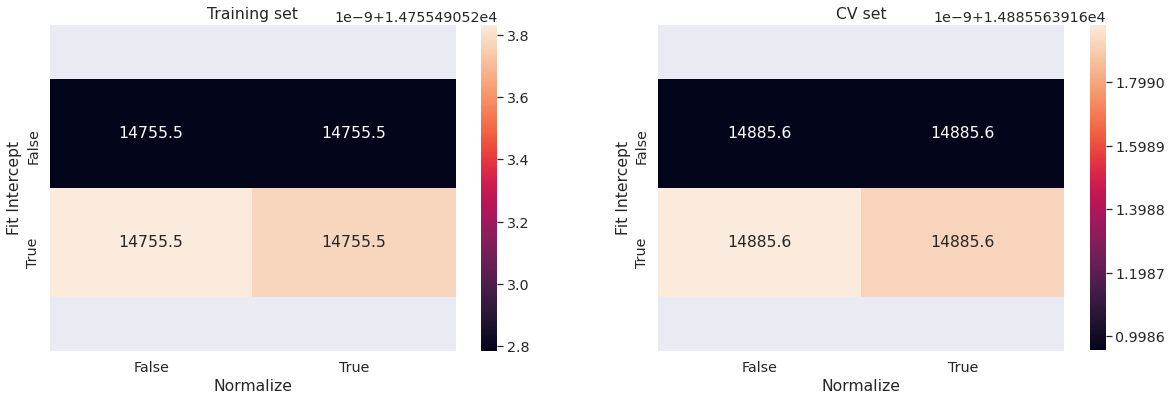

In [71]:
"""Creating heatmaps for Train loss and CV loss."""

sns.set(font_scale=1.3)
train_lr = pd.pivot_table(lr_dataframe,'Train Error','Fit Intercept','Normalize') # Train Pivot table
cv_lr = pd.pivot_table(lr_dataframe, 'CV Error','Fit Intercept','Normalize') # CV Pivot table.
fig, ax = plt.subplots(1,2, figsize=(20,6))
ax_train = sns.heatmap(train_lr, annot=True, fmt='4g', ax=ax[0]) # Train heatmap.
ax_cv = sns.heatmap(cv_lr, annot=True, fmt='4g', ax=ax[1]) # CV heatmap.

bottom_train, top_train = ax_train.get_ylim()
ax_train.set_ylim(bottom_train + 0.5, top_train - 0.5)

bottom_cv, top_cv = ax_cv.get_ylim()
ax_cv.set_ylim(bottom_cv + 0.5, top_cv - 0.5)

ax[0].set_title('Training set')
ax[1].set_title('CV set')
plt.show()

In [72]:
"""Calculate Prediction and WMAE score."""

model_linear_reg = LinearRegression(fit_intercept=True,normalize=True).fit(X_train,y_train) # Fit the model.
y_pred = model_linear_reg.predict(X_test) # Predict test data.
print('Weighted Mean Absolute Error (WMAE) for Linear Regression:', wmae_test(y_test, y_pred)) # Calculate WMAE score.

Weighted Mean Absolute Error (WMAE) for Linear Regression: 14781.35040615615


In [74]:
# # Define the list of errors and list of hyper parameters.
# error_cv_rf = []
# error_train_rf = []
# max_depth = [1,5,10,15,20,25,30,35]
# n_estimators = [10,20,30,40,50,60,70,80]
# rf_hyperparams = []

# """Calculating train and CV errors for maximum depth and number of estimators parameters."""

# for i in max_depth: # Loop over max_depth.
#     for j in n_estimators: # Loop over n_estimators. 
#         rf = RandomForestRegressor(max_depth=i, n_estimators=j) # Apply Random Forest Regressor.
#         rf.fit(X_train, y_train) # Fit the model.
#         y_pred_cv_rf = rf.predict(X_cv) # Predict CV data.
#         y_pred_train_rf = rf.predict(X_train) # Predict Train data.
#         error_cv_rf.append(wmae_cv(y_cv, y_pred_cv_rf)) # Get CV error.
#         error_train_rf.append(wmae_train(y_train, y_pred_train_rf)) # Get Train error.
#         rf_hyperparams.append({'Maximum Depth':i, 'No. of Estimators':j}) # Get list of hyper parameter values.

In [75]:
"""Calculate Prediction and  WMAE score."""

model_rf = RandomForestRegressor(max_depth= 35, n_estimators=80).fit(X_train, y_train) # Fit the model with best hyper parameter values.
y_pred = model_rf.predict(X_test) # Predict the test data.
print('Weighted Mean Absolute Error (WMAE) for Random Forest Regression:', wmae_test(y_test, y_pred)) # Get WMAE score.

Weighted Mean Absolute Error (WMAE) for Random Forest Regression: 1787.0114520444897


In [76]:
#Reading kaggle provided test file for which the prediction is needed.
test_kaggle = pd.read_csv('test.csv')
test_kaggle.head()

,Store,Dept,Date,IsHoliday
0,1,1,2012-11-02,False
1,1,1,2012-11-09,False
2,1,1,2012-11-16,False
3,1,1,2012-11-23,True
4,1,1,2012-11-30,False


In [77]:
test_kaggle = test_kaggle.merge(features, on=['Store', 'Date'], how='inner').merge(stores, on=['Store'], how='inner') # Joining test data with store and features.
print(test_kaggle.shape)

# Making IsHoliday as one column.
test_kaggle = test_kaggle.drop(['IsHoliday_y'], axis=1)
test_kaggle = test_kaggle.rename(columns={'IsHoliday_x':'IsHoliday'})
print('Test_Kaggle columns:\n', test_kaggle.columns)

# Converting Date to datetime
test_kaggle['Date'] = pd.to_datetime(test_kaggle['Date'])

# Extract date features
test_kaggle['Date_dayofweek'] = test_kaggle['Date'].dt.dayofweek
test_kaggle['Date_month'] = test_kaggle['Date'].dt.month 
test_kaggle['Date_year'] = test_kaggle['Date'].dt.year
test_kaggle['Date_day'] = test_kaggle['Date'].dt.day 


(115064, 16)
Test_Kaggle columns:
 Index(['Store', 'Dept', 'Date', 'IsHoliday', 'Temperature', 'Fuel_Price',
       'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI',
       'Unemployment', 'Type', 'Size'],
      dtype='object')


In [78]:
test_kaggle_data = [test_kaggle]

# Converting Categorical Variable 'Type' into Numerical Variables.
type_mapping = {"A": 1, "B": 2, "C": 3}
for dataset in test_kaggle_data:
    dataset['Type'] = dataset['Type'].map(type_mapping)

# Converting Categorical Variable 'IsHoliday' into Numerical Variables.
type_mapping = {False: 0, True: 1}
for dataset in test_kaggle_data:
    dataset['IsHoliday'] = dataset['IsHoliday'].map(type_mapping)
#test = test.drop(['Date'], axis=1)


In [79]:
# Special holidays.
test_kaggle['Super_Bowl'] = np.where((test_kaggle['Date'] == datetime(2010,2,10)) | (test_kaggle['Date'] == datetime(2011,2,11)) | 
                               (test_kaggle['Date'] == datetime(2012,2,10)) | (test_kaggle['Date'] == datetime(2013,2,8)), 1, 0)
test_kaggle['Labor_day'] = np.where((test_kaggle['Date'] == datetime(2010,9,10)) | (test_kaggle['Date'] == datetime(2011,9,9)) | 
                              (test_kaggle['Date'] == datetime(2012,9,7)) | (test_kaggle['Date'] == datetime(2013,9,6)), 1, 0)
test_kaggle['Thanksgiving'] = np.where((test_kaggle['Date']==datetime(2010, 11, 26)) | (test_kaggle['Date']==datetime(2011, 11, 25)) | 
                                 (test_kaggle['Date']==datetime(2012, 11, 23)) | (test_kaggle['Date']==datetime(2013, 11, 29)),1,0)
test_kaggle['Christmas'] = np.where((test_kaggle['Date']==datetime(2010, 12, 31)) | (test_kaggle['Date']==datetime(2011, 12, 30)) | 
                              (test_kaggle['Date']==datetime(2012, 12, 28)) | (test_kaggle['Date']==datetime(2013, 12, 27)),1,0)

In [80]:
# Since we have Imputed IsHoliday according to Extra holidays..These extra holiday variable has redundant.
# Dropping the Extra holiday variables because its redundant.
dp = ['Super_Bowl','Labor_day','Thanksgiving','Christmas']
test_kaggle.drop(dp, axis=1, inplace=True)

In [81]:
test_kaggle = test_kaggle.fillna(0) # Filling null values with 0.

In [82]:
test_kaggle.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 115064 entries, 0 to 115063
Data columns (total 19 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   Store           115064 non-null  int64         
 1   Dept            115064 non-null  int64         
 2   Date            115064 non-null  datetime64[ns]
 3   IsHoliday       115064 non-null  int64         
 4   Temperature     115064 non-null  float64       
 5   Fuel_Price      115064 non-null  float64       
 6   MarkDown1       115064 non-null  float64       
 7   MarkDown2       115064 non-null  float64       
 8   MarkDown3       115064 non-null  float64       
 9   MarkDown4       115064 non-null  float64       
 10  MarkDown5       115064 non-null  float64       
 11  CPI             115064 non-null  float64       
 12  Unemployment    115064 non-null  float64       
 13  Type            115064 non-null  int64         
 14  Size            115064 non-null  int

In [83]:
# Removing unimportant features.
features_drop=['Unemployment','CPI','MarkDown5']
test_kaggle = test_kaggle.drop(features_drop, axis=1)

In [84]:
#Excluding Date as it throws error while making prediction.
test_kaggle = test_kaggle.loc[:, test_kaggle.columns != 'Date']

In [85]:
print('Final test_kaggle shape:', test_kaggle.shape)
test_kaggle.head(2)

Final test_kaggle shape: (115064, 15)


,Store,Dept,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,Type,Size,Date_dayofweek,Date_month,Date_year,Date_day
0,1,1,0,55.32,3.386,6766.44,5147.7,50.82,3639.9,1,151315,4,11,2012,2
1,1,2,0,55.32,3.386,6766.44,5147.7,50.82,3639.9,1,151315,4,11,2012,2


In [88]:
y=train["Weekly_Sales"]
y

0         24924.50
330761    14612.19
330762    26323.15
330763    36414.63
330764    11437.81
            ...   
330702     8930.71
330703     4841.81
330704     7035.13
330706     2124.60
421569     1076.80
Name: Weekly_Sales, Length: 420285, dtype: float64

In [89]:
traincopy=train.copy()
traincopy

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,Type,Size,Date_dayofweek,Date_month,Date_year,Date_day
0,1,1,2010-02-05,24924.50,0,42.31,2.572,0.00,0.00,0.0,0.00,1,151315,4,2,2010,5
330761,35,3,2010-02-05,14612.19,0,27.19,2.784,0.00,0.00,0.0,0.00,2,103681,4,2,2010,5
330762,35,4,2010-02-05,26323.15,0,27.19,2.784,0.00,0.00,0.0,0.00,2,103681,4,2,2010,5
330763,35,5,2010-02-05,36414.63,0,27.19,2.784,0.00,0.00,0.0,0.00,2,103681,4,2,2010,5
330764,35,6,2010-02-05,11437.81,0,27.19,2.784,0.00,0.00,0.0,0.00,2,103681,4,2,2010,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
330702,34,14,2012-10-26,8930.71,0,57.95,3.514,1151.88,68.01,3.0,392.12,1,158114,4,10,2012,26
330703,34,16,2012-10-26,4841.81,0,57.95,3.514,1151.88,68.01,3.0,392.12,1,158114,4,10,2012,26
330704,34,17,2012-10-26,7035.13,0,57.95,3.514,1151.88,68.01,3.0,392.12,1,158114,4,10,2012,26
330706,34,20,2012-10-26,2124.60,0,57.95,3.514,1151.88,68.01,3.0,392.12,1,158114,4,10,2012,26


In [91]:
traincopy=traincopy.drop(['Weekly_Sales'],axis=1)
traincopy

,Store,Dept,Date,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,Type,Size,Date_dayofweek,Date_month,Date_year,Date_day
0,1,1,2010-02-05,0,42.31,2.572,0.00,0.00,0.0,0.00,1,151315,4,2,2010,5
330761,35,3,2010-02-05,0,27.19,2.784,0.00,0.00,0.0,0.00,2,103681,4,2,2010,5
330762,35,4,2010-02-05,0,27.19,2.784,0.00,0.00,0.0,0.00,2,103681,4,2,2010,5
330763,35,5,2010-02-05,0,27.19,2.784,0.00,0.00,0.0,0.00,2,103681,4,2,2010,5
330764,35,6,2010-02-05,0,27.19,2.784,0.00,0.00,0.0,0.00,2,103681,4,2,2010,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
330702,34,14,2012-10-26,0,57.95,3.514,1151.88,68.01,3.0,392.12,1,158114,4,10,2012,26
330703,34,16,2012-10-26,0,57.95,3.514,1151.88,68.01,3.0,392.12,1,158114,4,10,2012,26
330704,34,17,2012-10-26,0,57.95,3.514,1151.88,68.01,3.0,392.12,1,158114,4,10,2012,26
330706,34,20,2012-10-26,0,57.95,3.514,1151.88,68.01,3.0,392.12,1,158114,4,10,2012,26


In [101]:
#traincopy['Date']=traincopy['Date'].map(datetime.toordinal)
traincopy=traincopy.drop(["Date"],axis=1)
traincopy.dtypes

Store               int64
Dept                int64
IsHoliday           int64
Temperature       float64
Fuel_Price        float64
MarkDown1         float64
MarkDown2         float64
MarkDown3         float64
MarkDown4         float64
Type                int64
Size                int64
Date_dayofweek      int64
Date_month          int64
Date_year           int64
Date_day            int64
dtype: object

In [99]:
test_kaggle.dtypes

Store               int64
Dept                int64
IsHoliday           int64
Temperature       float64
Fuel_Price        float64
MarkDown1         float64
MarkDown2         float64
MarkDown3         float64
MarkDown4         float64
Type                int64
Size                int64
Date_dayofweek      int64
Date_month          int64
Date_year           int64
Date_day            int64
dtype: object

In [102]:
# Applying Random Forest to kaggle provided test file with the best hyper parameter values we got during training phase in Random Forest.
model_rf = RandomForestRegressor(max_depth= 35, n_estimators=80).fit(traincopy,y) # Fit the model with original train data.
y_pred = model_rf.predict(test_kaggle) # Predict the final test data that Kaggle has provided.

In [103]:
y_pred

array([32948.22075 , 47799.968625, 11268.084125, ..., 59429.562   ,
        6617.98075 ,   734.398125])

In [106]:
test_kaggle_final=pd.read_csv('test.csv')
test_kaggle_final

,Store,Dept,Date,IsHoliday
0,1,1,2012-11-02,False
1,1,1,2012-11-09,False
2,1,1,2012-11-16,False
3,1,1,2012-11-23,True
4,1,1,2012-11-30,False
...,...,...,...,...
115059,45,98,2013-06-28,False
115060,45,98,2013-07-05,False
115061,45,98,2013-07-12,False
115062,45,98,2013-07-19,False


In [110]:
finalpred = pd.DataFrame({
        "Store_Dept_Date": test_kaggle_final.Store.astype(str)+'_'+test_kaggle_final.Dept.astype(str)+'_'+test_kaggle_final.Date.astype(str), # Preparing in the format provided in samplesubmission.csv.
        "Weekly_Sales": y_pred # This is predicetd Weekly Sales on final test data using Random Forest regression.
    })

finalpred.to_csv('Weekly Sales Prediction.csv', index=False) 

In [114]:
finalpred

,Store_Dept_Date,Weekly_Sales
0,1_1_2012-11-02,32948.220750
1,1_1_2012-11-09,47799.968625
2,1_1_2012-11-16,11268.084125
3,1_1_2012-11-23,39139.680375
4,1_1_2012-11-30,31703.801500
...,...,...
115059,45_98_2013-06-28,3839.315500
115060,45_98_2013-07-05,4314.053625
115061,45_98_2013-07-12,59429.562000
115062,45_98_2013-07-19,6617.980750
